In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('data/store.csv')

In [3]:
df.head()

date  price  qty  sell_id  sell_cat      item  year   holiday  \
0  1/1/12  15.50   46     1070         0    BURGER  2012  New Year   
1  1/1/12  12.73   22     2051         2    BURGER  2012  New Year   
2  1/1/12  12.73   22     2051         2      COKE  2012  New Year   
3  1/1/12  12.75   18     2052         2    BURGER  2012  New Year   
4  1/1/12  12.75   18     2052         2  LEMONADE  2012  New Year   

   is_weekend  is_schoolbreak  avg_temperature  is_outdoor  
0           1               0             24.8           0  
1           1               0             24.8           0  
2           1               0             24.8           0  
3           1               0             24.8           0  
4           1               0             24.8           0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10840 entries, 0 to 10839
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             10840 non-null  object 
 1   price            10840 non-null  float64
 2   qty              10840 non-null  int64  
 3   sell_id          10840 non-null  int64  
 4   sell_cat         10840 non-null  int64  
 5   item             10840 non-null  object 
 6   year             10840 non-null  int64  
 7   holiday          840 non-null    object 
 8   is_weekend       10840 non-null  int64  
 9   is_schoolbreak   10840 non-null  int64  
 10  avg_temperature  10840 non-null  float64
 11  is_outdoor       10840 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 1016.4+ KB


In [5]:
df.describe(include="all")

date         price           qty       sell_id      sell_cat  \
count    10840  10840.000000  10840.000000  10840.000000  10840.000000   
unique    1348           NaN           NaN           NaN           NaN   
top     3/1/13           NaN           NaN           NaN           NaN   
freq        64           NaN           NaN           NaN           NaN   
mean       NaN     12.469232     39.928044   1929.375000      1.750000   
std        NaN      1.332332     20.937454    324.829137      0.661468   
min        NaN     10.120000      8.000000   1070.000000      0.000000   
25%        NaN     11.480000     24.000000   2051.000000      2.000000   
50%        NaN     12.460000     34.000000   2052.000000      2.000000   
75%        NaN     12.850000     50.000000   2053.000000      2.000000   
max        NaN     16.500000    124.000000   2053.000000      2.000000   

          item          year         holiday    is_weekend  is_schoolbreak  \
count    10840  10840.000000             840  10840.000000     10840.00000   
unique       4           NaN               8           NaN             NaN   
top     BURGER           NaN  Luner New Year           NaN             NaN   
freq      5420           NaN             224           NaN             NaN   
mean       NaN   2013.373432             NaN      0.284133         0.20369   
std        NaN      1.070637             NaN      0.451021         0.40276   
min        NaN   2012.000000             NaN      0.000000         0.00000   
25%        NaN   2012.000000             NaN      0.000000         0.00000   
50%        NaN   2013.000000             NaN      0.000000         0.00000   
75%        NaN   2014.000000             NaN      1.000000         0.00000   
max        NaN   2015.000000             NaN      1.000000         1.00000   

        avg_temperature    is_outdoor  
count      10840.000000  10840.000000  
unique              NaN           NaN  
top                 NaN           NaN  
freq                NaN           NaN  
mean          56.234244      0.862731  
std           20.224510      0.344147  
min           14.000000      0.000000  
25%           35.600000      1.000000  
50%           60.800000      1.000000  
75%           75.200000      1.000000  
max           87.800000      1.000000

In [6]:
# Transform item and holiday to cateogry
df['item'] = df['item'].astype('category')
df['holiday'] = df['holiday'].astype('category')

In [7]:
# Transform date feature to date type
df['date'] = pd.to_datetime(df["date"],format="%m/%d/%y")

In [8]:
profile = ProfileReport(df)
profile

### First notes:
    
        1.- Qty (the target) and price are bimodal and both have some outliers.
        2.- There is a linear correlation among them.
        3.- There are nulls in the feature holiday.
        4.- There are duplicated rows. Each date should be unique per sell_id-item and 2013-03-01 is repeated.
        5.- QTY is highly linear correlated to sell_id, sell_cat and also to is_weekend and price.
        

### Check nulls

In [9]:
df.isnull().sum()

date                   0
price                  0
qty                    0
sell_id                0
sell_cat               0
item                   0
year                   0
holiday            10000
is_weekend             0
is_schoolbreak         0
avg_temperature        0
is_outdoor             0
dtype: int64

There are nulls in holiday. This may mean a 0, but let´s see.

In [10]:
df['holiday'].value_counts()

Luner New Year          224
National Day            168
Qing Ming Festival       96
Labor Day                96
Dragon Boat Festivel     96
New Year                 80
Mid-Autumn Day           56
WWII Celebration         24
Name: holiday, dtype: int64

In [11]:
df[df['holiday'].isnull()]

date  price  qty  sell_id  sell_cat      item  year holiday  \
24    2012-01-04  15.50   88     1070         0    BURGER  2012     NaN   
25    2012-01-04  12.73   26     2051         2    BURGER  2012     NaN   
26    2012-01-04  12.73   26     2051         2      COKE  2012     NaN   
27    2012-01-04  12.75   24     2052         2    BURGER  2012     NaN   
28    2012-01-04  12.75   24     2052         2  LEMONADE  2012     NaN   
...          ...    ...  ...      ...       ...       ...   ...     ...   
10835 2015-09-10  11.50   18     2052         2    BURGER  2015     NaN   
10836 2015-09-10  11.50   18     2052         2  LEMONADE  2015     NaN   
10837 2015-09-10  11.26   50     2053         2    BURGER  2015     NaN   
10838 2015-09-10  11.26   50     2053         2      COKE  2015     NaN   
10839 2015-09-10  11.26   50     2053         2    COFFEE  2015     NaN   

       is_weekend  is_schoolbreak  avg_temperature  is_outdoor  
24              0               0             32.0           1  
25              0               0             32.0           1  
26              0               0             32.0           1  
27              0               0             32.0           1  
28              0               0             32.0           1  
...           ...             ...              ...         ...  
10835           0               0             73.4           1  
10836           0               0             73.4           1  
10837           0               0             73.4           1  
10838           0               0             73.4           1  
10839           0               0             73.4           1  

[10000 rows x 12 columns]

That´s it. We will label encode and create a binary is_holiday and see which one perfoms better because I think that some holidays are more asociated to go to a cafe than others.

In [12]:
# Replace NA
df['holiday'] = np.where(df['holiday'].isnull(),'No holiday',df['holiday'])

In [13]:
# binary features
df['is_holiday'] = np.where(df['holiday'] == "No holiday",0,1)

In [14]:
# label encoder
encoder = LabelEncoder()
df['holiday']  = encoder.fit_transform(df['holiday'] )

Later we will check which one is more correlated to quantity and reomve the less correlated one

### Duplicates

In [17]:
dupli = df[df['date'] == '2013-03-01']
dupli

date  price  qty  sell_id  sell_cat    item  year  holiday  \
3392 2013-03-01  15.50   90     1070         0  BURGER  2013        6   
3393 2013-03-01  15.50   90     1070         0  BURGER  2013        6   
3394 2013-03-01  15.50   90     2051         2  BURGER  2013        6   
3395 2013-03-01  15.50   90     2051         2  BURGER  2013        6   
3396 2013-03-01  15.50   90     2051         2    COKE  2013        6   
...         ...    ...  ...      ...       ...     ...   ...      ...   
3451 2013-03-01  13.41   40     2053         2  BURGER  2013        6   
3452 2013-03-01  13.41   40     2053         2    COKE  2013        6   
3453 2013-03-01  13.41   40     2053         2    COKE  2013        6   
3454 2013-03-01  13.41   40     2053         2  COFFEE  2013        6   
3455 2013-03-01  13.41   40     2053         2  COFFEE  2013        6   

      is_weekend  is_schoolbreak  avg_temperature  is_outdoor  is_holiday  
3392           0               0             39.2           1           0  
3393           0               0             32.0           1           0  
3394           0               0             39.2           1           0  
3395           0               0             32.0           1           0  
3396           0               0             39.2           1           0  
...          ...             ...              ...         ...         ...  
3451           0               0             32.0           1           0  
3452           0               0             39.2           1           0  
3453           0               0             32.0           1           0  
3454           0               0             39.2           1           0  
3455           0               0             32.0           1           0  

[64 rows x 13 columns]

The quantity seems so high and as we saw previously it has different holidays in the same day

In [25]:
dupli[['sell_id','item']].value_counts()

sell_id  item    
2053     COKE        8
         COFFEE      8
         BURGER      8
2052     LEMONADE    8
         BURGER      8
2051     COKE        8
         BURGER      8
1070     BURGER      8
dtype: int64

8 sell_id-item * 8 each = 64 = the number of duplicates. That means that each pair is duplicated 8 times.

In [35]:
dupli[['sell_id','item','qty','avg_temperature','price']].value_counts().to_frame()

0
sell_id item     qty avg_temperature price   
2053    COKE     40  39.2            13.41  2
        COFFEE   40  32.0            13.41  2
        BURGER   40  32.0            13.41  2
                     39.2            13.41  2
2052    BURGER   40  39.2            13.41  2
        LEMONADE 40  39.2            13.41  2
1070    BURGER   90  39.2            15.50  2
2052    BURGER   40  32.0            13.41  2
2053    COFFEE   40  39.2            13.41  2
1070    BURGER   90  32.0            15.50  2
2053    COKE     40  32.0            13.41  2
2052    LEMONADE 40  32.0            13.41  2
2051    COKE     22  32.0            12.64  1
                     39.2            12.64  1
                 88  32.0            15.50  1
                 16  39.2            12.64  1
                     32.0            12.64  1
        BURGER   90  39.2            15.50  1
                 88  32.0            15.50  1
                 90  32.0            15.50  1
                 88  39.2            15.50  1
        COKE     90  32.0            15.50  1
        BURGER   22  39.2            12.64  1
                     32.0            12.64  1
                 16  39.2            12.64  1
                     32.0            12.64  1
1070    BURGER   24  39.2            12.64  1
                     32.0            12.64  1
                 18  39.2            12.64  1
2051    COKE     88  39.2            15.50  1
2052    BURGER   30  39.2            13.13  1
2051    COKE     90  39.2            15.50  1
2053    BURGER   26  39.2            13.13  1
        COKE     26  39.2            13.13  1
                     32.0            13.13  1
                 24  39.2            13.13  1
                     32.0            13.13  1
        COFFEE   26  39.2            13.13  1
                     32.0            13.13  1
                 24  39.2            13.13  1
                     32.0            13.13  1
        BURGER   26  32.0            13.13  1
2052    BURGER   26  32.0            13.13  1
2053    BURGER   24  39.2            13.13  1
                     32.0            13.13  1
2052    LEMONADE 30  39.2            13.13  1
                     32.0            13.13  1
                 26  39.2            13.13  1
                     32.0            13.13  1
        BURGER   30  32.0            13.13  1
                 26  39.2            13.13  1
1070    BURGER   18  32.0            12.64  1

Each pair has different quantities, prices and avg tmp for the same day. I don´t see what is going on so I will se what happened the previous and the next day to try to clarify it.

In [32]:
dupli_1 = df[df['date'] == '2013-03-02']
dupli_1

date  price  qty  sell_id  sell_cat      item  year  holiday  \
3456 2013-03-02  15.50   58     1070         0    BURGER  2013        6   
3457 2013-03-02  13.13   18     2051         2    BURGER  2013        6   
3458 2013-03-02  13.13   18     2051         2      COKE  2013        6   
3459 2013-03-02  12.64   20     2052         2    BURGER  2013        6   
3460 2013-03-02  12.64   20     2052         2  LEMONADE  2013        6   
3461 2013-03-02  13.41   26     2053         2    BURGER  2013        6   
3462 2013-03-02  13.41   26     2053         2      COKE  2013        6   
3463 2013-03-02  13.41   26     2053         2    COFFEE  2013        6   

      is_weekend  is_schoolbreak  avg_temperature  is_outdoor  is_holiday  
3456           1               0             35.6           1           0  
3457           1               0             35.6           1           0  
3458           1               0             35.6           1           0  
3459           1               0             35.6           1           0  
3460           1               0             35.6           1           0  
3461           1               0             35.6           1           0  
3462           1               0             35.6           1           0  
3463           1               0             35.6           1           0

In [33]:
dupli_2 = df[df['date'] == '2013-02-28']
dupli_2

date  price  qty  sell_id  sell_cat      item  year  holiday  \
3384 2013-02-28  15.50   84     1070         0    BURGER  2013        6   
3385 2013-02-28  13.13   28     2051         2    BURGER  2013        6   
3386 2013-02-28  13.13   28     2051         2      COKE  2013        6   
3387 2013-02-28  12.64   22     2052         2    BURGER  2013        6   
3388 2013-02-28  12.64   22     2052         2  LEMONADE  2013        6   
3389 2013-02-28  13.41   44     2053         2    BURGER  2013        6   
3390 2013-02-28  13.41   44     2053         2      COKE  2013        6   
3391 2013-02-28  13.41   44     2053         2    COFFEE  2013        6   

      is_weekend  is_schoolbreak  avg_temperature  is_outdoor  is_holiday  
3384           0               0             35.6           1           0  
3385           0               0             35.6           1           0  
3386           0               0             35.6           1           0  
3387           0               0             35.6           1           0  
3388           0               0             35.6           1           0  
3389           0               0             35.6           1           0  
3390           0               0             35.6           1           0  
3391           0               0             35.6           1           0

It is probably a mistake so we will manually see which values fit better observing the previous and next day values per pair sell_id-item. For example: the burger 1070 qty shouldn´t be 24 because the previous day was 58 and the next 84 so 90 seems more reasonable.

In [50]:
days = df[(df['date'] == '2013-02-28') | (df['date'] == '2013-03-02')]
days.groupby(['sell_id','item'])['qty','price'].mean().dropna()

<ipython-input-50-7dc0ce878687>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  days.groupby(['sell_id','item'])['qty','price'].mean().dropna()


qty  price
sell_id item                 
1070    BURGER    71.0  15.50
2051    BURGER    23.0  13.13
        COKE      23.0  13.13
2052    BURGER    21.0  12.64
        LEMONADE  21.0  12.64
2053    BURGER    35.0  13.41
        COFFEE    35.0  13.41
        COKE      35.0  13.41

In [63]:
dup_1070 = dupli[dupli['sell_id'] == 1070]
dup_1070

date  price  qty  sell_id  sell_cat    item  year  holiday  \
3392 2013-03-01  15.50   90     1070         0  BURGER  2013        6   
3393 2013-03-01  15.50   90     1070         0  BURGER  2013        6   
3408 2013-03-01  12.64   24     1070         0  BURGER  2013        6   
3409 2013-03-01  12.64   24     1070         0  BURGER  2013        6   
3424 2013-03-01  15.50   90     1070         0  BURGER  2013        6   
3425 2013-03-01  15.50   90     1070         0  BURGER  2013        6   
3440 2013-03-01  12.64   18     1070         0  BURGER  2013        6   
3441 2013-03-01  12.64   18     1070         0  BURGER  2013        6   

      is_weekend  is_schoolbreak  avg_temperature  is_outdoor  is_holiday  
3392           0               0             39.2           1           0  
3393           0               0             32.0           1           0  
3408           0               0             39.2           1           0  
3409           0               0             32.0           1           0  
3424           0               0             39.2           1           0  
3425           0               0             32.0           1           0  
3440           0               0             39.2           1           0  
3441           0               0             32.0           1           0

In [67]:
def get_real_value(dataframe,qty,price,avg_tmp=32):
    return dataframe[(dataframe['qty'] == qty) & (dataframe['price'] == price) & (dataframe['avg_temperature'] == avg_tmp) ].drop_duplicates()

In [64]:
dup_1070 = get_real_value(dup_1070,90,15.50,32) 

In [74]:
dup_2051 = dupli[(dupli['sell_id'] == 2051)]
dup_2051

date  price  qty  sell_id  sell_cat    item  year  holiday  \
3394 2013-03-01  15.50   90     2051         2  BURGER  2013        6   
3395 2013-03-01  15.50   90     2051         2  BURGER  2013        6   
3396 2013-03-01  15.50   90     2051         2    COKE  2013        6   
3397 2013-03-01  15.50   90     2051         2    COKE  2013        6   
3410 2013-03-01  12.64   22     2051         2  BURGER  2013        6   
3411 2013-03-01  12.64   22     2051         2  BURGER  2013        6   
3412 2013-03-01  12.64   22     2051         2    COKE  2013        6   
3413 2013-03-01  12.64   22     2051         2    COKE  2013        6   
3426 2013-03-01  15.50   88     2051         2  BURGER  2013        6   
3427 2013-03-01  15.50   88     2051         2  BURGER  2013        6   
3428 2013-03-01  15.50   88     2051         2    COKE  2013        6   
3429 2013-03-01  15.50   88     2051         2    COKE  2013        6   
3442 2013-03-01  12.64   16     2051         2  BURGER  2013        6   
3443 2013-03-01  12.64   16     2051         2  BURGER  2013        6   
3444 2013-03-01  12.64   16     2051         2    COKE  2013        6   
3445 2013-03-01  12.64   16     2051         2    COKE  2013        6   

      is_weekend  is_schoolbreak  avg_temperature  is_outdoor  is_holiday  
3394           0               0             39.2           1           0  
3395           0               0             32.0           1           0  
3396           0               0             39.2           1           0  
3397           0               0             32.0           1           0  
3410           0               0             39.2           1           0  
3411           0               0             32.0           1           0  
3412           0               0             39.2           1           0  
3413           0               0             32.0           1           0  
3426           0               0             39.2           1           0  
3427           0               0             32.0           1           0  
3428           0               0             39.2           1           0  
3429           0               0             32.0           1           0  
3442           0               0             39.2           1           0  
3443           0               0             32.0           1           0  
3444           0               0             39.2           1           0  
3445           0               0             32.0           1           0

In [75]:
dup_2051 = get_real_value(dup_2051,22,12.64)

In [76]:
dup_2052 = dupli[(dupli['sell_id'] == 2052)]
dup_2052

date  price  qty  sell_id  sell_cat      item  year  holiday  \
3398 2013-03-01  13.13   30     2052         2    BURGER  2013        6   
3399 2013-03-01  13.13   30     2052         2    BURGER  2013        6   
3400 2013-03-01  13.13   30     2052         2  LEMONADE  2013        6   
3401 2013-03-01  13.13   30     2052         2  LEMONADE  2013        6   
3414 2013-03-01  13.41   40     2052         2    BURGER  2013        6   
3415 2013-03-01  13.41   40     2052         2    BURGER  2013        6   
3416 2013-03-01  13.41   40     2052         2  LEMONADE  2013        6   
3417 2013-03-01  13.41   40     2052         2  LEMONADE  2013        6   
3430 2013-03-01  13.13   26     2052         2    BURGER  2013        6   
3431 2013-03-01  13.13   26     2052         2    BURGER  2013        6   
3432 2013-03-01  13.13   26     2052         2  LEMONADE  2013        6   
3433 2013-03-01  13.13   26     2052         2  LEMONADE  2013        6   
3446 2013-03-01  13.41   40     2052         2    BURGER  2013        6   
3447 2013-03-01  13.41   40     2052         2    BURGER  2013        6   
3448 2013-03-01  13.41   40     2052         2  LEMONADE  2013        6   
3449 2013-03-01  13.41   40     2052         2  LEMONADE  2013        6   

      is_weekend  is_schoolbreak  avg_temperature  is_outdoor  is_holiday  
3398           0               0             39.2           1           0  
3399           0               0             32.0           1           0  
3400           0               0             39.2           1           0  
3401           0               0             32.0           1           0  
3414           0               0             39.2           1           0  
3415           0               0             32.0           1           0  
3416           0               0             39.2           1           0  
3417           0               0             32.0           1           0  
3430           0               0             39.2           1           0  
3431           0               0             32.0           1           0  
3432           0               0             39.2           1           0  
3433           0               0             32.0           1           0  
3446           0               0             39.2           1           0  
3447           0               0             32.0           1           0  
3448           0               0             39.2           1           0  
3449           0               0             32.0           1           0

In [77]:
dup_2052 = get_real_value(dup_2052,26,13.13)

In [79]:
dup_2053 = dupli[(dupli['sell_id'] == 2053)]
dup_2053

date  price  qty  sell_id  sell_cat    item  year  holiday  \
3402 2013-03-01  13.13   26     2053         2  BURGER  2013        6   
3403 2013-03-01  13.13   26     2053         2  BURGER  2013        6   
3404 2013-03-01  13.13   26     2053         2    COKE  2013        6   
3405 2013-03-01  13.13   26     2053         2    COKE  2013        6   
3406 2013-03-01  13.13   26     2053         2  COFFEE  2013        6   
3407 2013-03-01  13.13   26     2053         2  COFFEE  2013        6   
3418 2013-03-01  13.41   40     2053         2  BURGER  2013        6   
3419 2013-03-01  13.41   40     2053         2  BURGER  2013        6   
3420 2013-03-01  13.41   40     2053         2    COKE  2013        6   
3421 2013-03-01  13.41   40     2053         2    COKE  2013        6   
3422 2013-03-01  13.41   40     2053         2  COFFEE  2013        6   
3423 2013-03-01  13.41   40     2053         2  COFFEE  2013        6   
3434 2013-03-01  13.13   24     2053         2  BURGER  2013        6   
3435 2013-03-01  13.13   24     2053         2  BURGER  2013        6   
3436 2013-03-01  13.13   24     2053         2    COKE  2013        6   
3437 2013-03-01  13.13   24     2053         2    COKE  2013        6   
3438 2013-03-01  13.13   24     2053         2  COFFEE  2013        6   
3439 2013-03-01  13.13   24     2053         2  COFFEE  2013        6   
3450 2013-03-01  13.41   40     2053         2  BURGER  2013        6   
3451 2013-03-01  13.41   40     2053         2  BURGER  2013        6   
3452 2013-03-01  13.41   40     2053         2    COKE  2013        6   
3453 2013-03-01  13.41   40     2053         2    COKE  2013        6   
3454 2013-03-01  13.41   40     2053         2  COFFEE  2013        6   
3455 2013-03-01  13.41   40     2053         2  COFFEE  2013        6   

      is_weekend  is_schoolbreak  avg_temperature  is_outdoor  is_holiday  
3402           0               0             39.2           1           0  
3403           0               0             32.0           1           0  
3404           0               0             39.2           1           0  
3405           0               0             32.0           1           0  
3406           0               0             39.2           1           0  
3407           0               0             32.0           1           0  
3418           0               0             39.2           1           0  
3419           0               0             32.0           1           0  
3420           0               0             39.2           1           0  
3421           0               0             32.0           1           0  
3422           0               0             39.2           1           0  
3423           0               0             32.0           1           0  
3434           0               0             39.2           1           0  
3435           0               0             32.0           1           0  
3436           0               0             39.2           1           0  
3437           0               0             32.0           1           0  
3438           0               0             39.2           1           0  
3439           0               0             32.0           1           0  
3450           0               0             39.2           1           0  
3451           0               0             32.0           1           0  
3452           0               0             39.2           1           0  
3453           0               0             32.0           1           0  
3454           0               0             39.2           1           0  
3455           0               0             32.0           1           0

In [80]:
dup_2053 = get_real_value(dup_2053,40,13.41)

Now we have all the real values per each product

In [86]:
to_keep = pd.concat([dup_1070,dup_2051,dup_2052,dup_2053])

In [88]:
# Drop real values from duplicates df
dupli = dupli.drop(to_keep.index)

In [93]:
# Drop duplicates
df = df.drop(dupli.index)

# EDA

Text(0.5, 1.0, 'QTY and Price Relation')

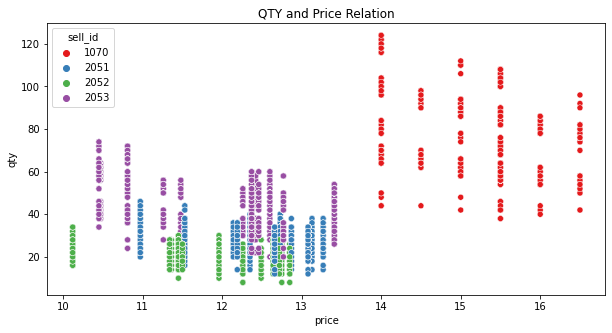

In [101]:
plt.figure(figsize=(10,5))
sns.scatterplot(df,x='price',y='qty',hue='sell_id',palette='Set1')
plt.title('QTY and Price Relation')

Text(0.5, 1.0, 'Price by sell id')

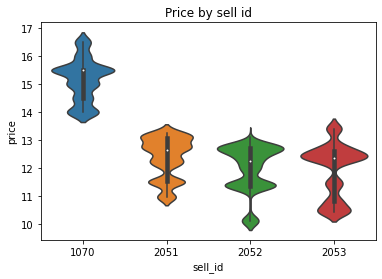

In [116]:
sns.violinplot(df,x='sell_id',y='price')
plt.title('Price by sell id')

Text(0.5, 1.0, 'QTY by sell id')

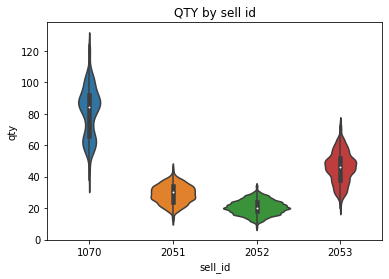

In [117]:
sns.violinplot(df,x='sell_id',y='qty')
plt.title('QTY by sell id')

Of this 3 charts we can observe that:

    1.- The 1070 has a different set of price and quantity (more expensive and more quantity) than the combos.
    2.- 1070 has different price distribution but the others are similar.
    3.- The 1070 quantity is more spread. All products have different qty distribution.
    4.- Split by sell_id would be a good idea to optimize the prices since they have different distributions.

As we saw earlier, quantity and price have a bimodal distribution and the explanation of this can be the differences between the products.

<AxesSubplot:xlabel='qty', ylabel='Density'>

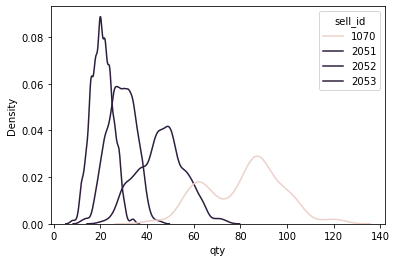

In [114]:
sns.kdeplot(df,x="qty",hue='sell_id',common_norm=False)

<AxesSubplot:xlabel='price', ylabel='Density'>

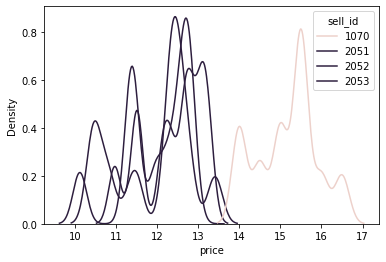

In [115]:
sns.kdeplot(df,x="price",hue='sell_id',common_norm=False)

We can see that the bimodal was caused by that because in qty the unique bimodel is the 1070 distribution and each sell_id has different range and distribution (the combo ones are similar).

In the case of price the distributions look more similar but the range of the 1070 is totally different as we saw in the violin plots.

Definelty we should split into different datasets and make one model for each product.

# Hacer:

    1.- Feature engineering
    2.- Scale y normalize qty y price por grupo